# MNIST data set loader

In [1]:
import gzip
import numpy as np
import os

def load_mnist(base='./'):

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
            
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Neural network class

In [2]:
import random
from tqdm import tqdm

def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

class Network(object):

    def __init__(self, sizes):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [ np.random.randn(y, 1) for y in sizes[1:] ]
        self.weights = [ np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:]) ]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
            
        return a

    def SGD(self, training_data, epochs, mini_batch_size,
            learning_rate, test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size) ]
            
            for mini_batch in tqdm(mini_batches):
                self.update_mini_batch(mini_batch, learning_rate)
                
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``"""
        nabla_b = [ np.zeros(b.shape) for b in self.biases ]
        nabla_w = [ np.zeros(w.shape) for w in self.weights ]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [ nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b) ]
            nabla_w = [ nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w) ]
        
        self.weights = [ w - (learning_rate / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w) ]
        
        self.biases = [ b - (learning_rate / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b) ]

    def backprop(self, x, y):
        """Returns a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function. ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [ np.zeros(b.shape) for b in self.biases ]
        nabla_w = [ np.zeros(w.shape) for w in self.weights ]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            #print  np.dot(w, activation).shape, w.shape, b.shape, z.shape
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
            
        nabla_b[-1] = delta
        #print delta.shape, activations[-2].shape
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result."""
        test_results = [ (np.argmax(self.feedforward(x)), np.argmax(y) )
                        for (x, y) in test_data ]
        
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Vector of partial derivatives for the cost function"""
        return (output_activations - y)

# Example

(784, 1) (50000, 10, 1)


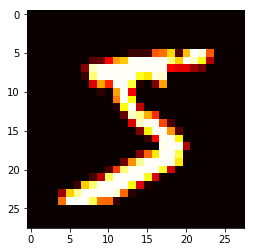

In [3]:
from matplotlib import pylab

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(-1, 28 * 28, 1) 
X_test = X_test.reshape(-1, 28 * 28, 1)
Y_train = np.zeros((len(y_train), 10, 1))
Y_test = np.zeros((len(y_test), 10, 1))

for i in xrange(len(y_train)):
    Y_train[i][y_train[i]] = 1.0

for i in xrange(len(y_test)):
    Y_test[i][y_test[i]] = 1.0

print X_train[0].shape, Y_train.shape
pylab.imshow(X_train[0].reshape(28, 28), cmap=pylab.cm.hot)
pylab.show()

In [4]:
training_set = [ (X_train[i,], Y_train[i]) for i in xrange(len(Y_train)) ] 
test_set = [ (X_test[i], Y_test[i]) for i in xrange(len(Y_test)) ]

In [5]:
Net = Network([28 * 28, 16, 10])

In [19]:
Net.SGD(training_set, 25, 50, 1.0)

  1%|          | 9/1000 [00:00<00:11, 82.71it/s]

Epoch 0 complete


  1%|          | 12/1000 [00:00<00:08, 119.85it/s]

Epoch 1 complete


  1%|▏         | 14/1000 [00:00<00:07, 138.78it/s]

Epoch 2 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3 complete


  2%|▏         | 15/1000 [00:00<00:06, 141.05it/s]

Epoch 4 complete


  1%|▏         | 14/1000 [00:00<00:07, 137.15it/s]

Epoch 5 complete


  1%|          | 9/1000 [00:00<00:11, 82.98it/s]

Epoch 6 complete


  1%|          | 12/1000 [00:00<00:08, 110.62it/s]

Epoch 7 complete


  1%|▏         | 14/1000 [00:00<00:07, 139.22it/s]

Epoch 8 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9 complete


  1%|          | 12/1000 [00:00<00:08, 117.30it/s]

Epoch 10 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11 complete


  1%|          | 12/1000 [00:00<00:08, 116.43it/s]

Epoch 12 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14 complete


  0%|          | 3/1000 [00:00<00:34, 29.28it/s]

Epoch 15 complete


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16 complete


  0%|          | 5/1000 [00:00<00:24, 40.65it/s]

Epoch 17 complete


  0%|          | 3/1000 [00:00<00:33, 29.64it/s]

Epoch 18 complete


  1%|          | 12/1000 [00:00<00:08, 119.90it/s]

Epoch 19 complete


  1%|          | 12/1000 [00:00<00:08, 113.36it/s]

Epoch 20 complete


  1%|▏         | 13/1000 [00:00<00:07, 126.59it/s]

Epoch 21 complete


  1%|          | 11/1000 [00:00<00:09, 109.30it/s]

Epoch 22 complete


  1%|          | 11/1000 [00:00<00:09, 102.77it/s]

Epoch 23 complete


100%|██████████| 1000/1000 [00:14<00:00, 68.93it/s]

Epoch 24 complete


In [18]:
print Net.evaluate(test_set)

9272
